In [1]:
import warnings 
warnings.filterwarnings('ignore')
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('.')
sys.path.append('..')
import yaml 
import argparse
import traceback
import time
import torch

from model.models import STSSL
from model.trainer import Trainer
from lib.dataloader import get_dataloader
from lib.utils import (
    init_seed,
    get_model_params,
    load_graph, 
)

In [2]:
import time
import yaml

# Define your configurations directly
configs = {
    'config_filename': 'configs/NYCTaxi.yaml',
    'S_Loss': 0,
    'T_Loss': 0,
    'seed': 1,
    'comment': "noComment",
    'cheb_order': 3,
    'graph_init': "8_neighbours",
    'self_attention_flag': True,
    'cross_attention_flag': False,
    'feedforward_flag': False,
    'layer_norm_flag': False,
    'additional_sa_flag': False,
    'learnable_flag': False,
    'rank': 0,
    'pos_emb_flag': False,
    'add_8': True,
    'add_eye': False,
    'add_x_encoder': False,
    'freeze_encoder': False,
    'ipe': 1
}

# Optionally print the starting experiment configurations
print(f"Starting experiment with configurations in {configs['config_filename']}...")

# Simulate a brief pause
time.sleep(3)

# Load configurations from a file (if necessary, or you could just use the dictionary as is)
with open(configs['config_filename'], 'r') as file:
    file_configs = yaml.load(file, Loader=yaml.FullLoader)
    configs.update(file_configs)

# You can add logic to modify configurations based on your conditions here
experiment_name = "pred_"
if configs['S_Loss'] == 1:
    experiment_name += "+S"
if configs['T_Loss'] == 1:
    experiment_name += "+T"
experiment_name += f"_seed={configs['seed']}"

configs['comment'] = "noComment"
configs['ipe'] = 1000
configs['loss'] = "mse"
configs['threshold_adj_mx'] = False
configs['affinity_conv'] = False
configs["experimentName"] = experiment_name

# Print the final configuration to start the experiment
print(f"Starting experiment with configurations {configs}...")
args = argparse.Namespace(**configs)

Starting experiment with configurations in configs/NYCTaxi.yaml...
Starting experiment with configurations {'config_filename': 'configs/NYCTaxi.yaml', 'S_Loss': 0, 'T_Loss': 0, 'seed': 1, 'comment': 'noComment', 'cheb_order': 3, 'graph_init': '8_neighbours', 'self_attention_flag': True, 'cross_attention_flag': False, 'feedforward_flag': False, 'layer_norm_flag': False, 'additional_sa_flag': False, 'learnable_flag': False, 'rank': 0, 'pos_emb_flag': False, 'add_8': True, 'add_eye': False, 'add_x_encoder': False, 'freeze_encoder': False, 'ipe': 1000, 'device': 'cuda', 'mode': 'train', 'best_path': 'None', 'debug': False, 'data_dir': 'data', 'dataset': 'NYCTaxi', 'input_length': 35, 'batch_size': 32, 'test_batch_size': 32, 'graph_file': 'data/NYCTaxi/adj_mx.npz', 'num_nodes': 200, 'row': 20, 'col': 10, 'd_input': 2, 'd_output': 2, 'd_model': 64, 'dropout': 0.1, 'percent': 0.1, 'shm_temp': 0.5, 'nmb_prototype': 4, 'yita': 0.5, 'start_epoch': 0, 'num_epochs': 1000, 'epochs': 1000, 'lr_init'

In [3]:
print(args.seed)

1


In [4]:
init_seed(args.seed)
if not torch.cuda.is_available():
    args.device = 'cuda'

## load dataset
dataloader = get_dataloader(
    data_dir=args.data_dir, 
    dataset=args.dataset, 
    batch_size=args.batch_size, 
    test_batch_size=args.test_batch_size,
    scalar_type='Standard'
)
graph = load_graph(args.graph_file, device=args.device)
args.num_nodes = len(graph)

## init model and set optimizer
model = STSSL(args).to(args.device)

# args.best_path = r"D:\omer\ST-SSL_simple2\experiments\NYCTaxi\pred__seed=5\20240712-190435\node_status (sigmoid) init=0 used in sconv no masking\best_model.pth"
args.best_path = r"D:\omer\ST-SSL_simple2\experiments\NYCTaxi\pred__seed=1\20240708-131122\mae, sa\best_model.pth"
state_dict = torch.load(
                args.best_path,
                map_location=torch.device(args.device)
            )

# Filter out unexpected keys
state_dict['model'] = {key: value for key, value in state_dict['model'].items() if key not in ['nodes_statusA', 'nodes_statusB']}
# state_dict['model'] = {key: value for key, value in state_dict['model'].items() if key not in ['encoderA.nodes_status', 'encoderB.nodes_status']}

# print all model parameters
# for name, param in model.named_parameters():
#     print(name, param.size())
msg = model.load_state_dict(state_dict['model'])
print("Load saved model msg: ", msg)

model_parameters = get_model_params([model])
optimizer = torch.optim.Adam(
    params=model_parameters, 
    lr=args.lr_init, 
    eps=1.0e-8, 
    weight_decay=0, 
    amsgrad=False
)



!!Scaling is NOT off!!


data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2) 

!!train shuffle is True!!


in else
in else
Load saved model msg:  <All keys matched successfully>


In [5]:
## start training
trainer = Trainer(
    model=model, 
    optimizer=optimizer, 
    dataloader=dataloader,
    graph=graph, 
    args=args
)

2024-07-25 17:29:34: 
Model has 1.141644 M trainable parameters
2024-07-25 17:29:34: Experiment log path in: D:\omer\ST-SSL_simple2\experiments\NYCTaxi\pred__seed=1\20240725-172934\noComment
2024-07-25 17:29:34: Experiment configs are: Namespace(S_Loss=0, T_Loss=0, add_8=True, add_eye=False, add_x_encoder=False, additional_sa_flag=False, affinity_conv=False, batch_size=32, best_path='D:\\omer\\ST-SSL_simple2\\experiments\\NYCTaxi\\pred__seed=1\\20240708-131122\\mae, sa\\best_model.pth', cheb_order=3, col=10, comment='noComment', config_filename='configs/NYCTaxi.yaml', cross_attention_flag=False, d_input=2, d_model=64, d_output=2, data_dir='data', dataset='NYCTaxi', debug=False, device='cuda', dropout=0.1, early_stop=True, early_stop_patience=35, epochs=1000, experimentName='pred__seed=1', feedforward_flag=False, freeze_encoder=False, grad_norm=True, graph_file='data/NYCTaxi/adj_mx.npz', graph_init='8_neighbours', input_length=35, ipe=1000, layer_norm_flag=False, learnable_flag=False, l

dummy forward pass done.
Creat Log File in:  D:\omer\ST-SSL_simple2\experiments\NYCTaxi\pred__seed=1\20240725-172934\noComment\run.log


In [17]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.metrics import test_metrics


def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            repr1, repr2 = model(data, graph)                
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)

    # y_true = torch.cat(y_true, dim=0).cpu().numpy()
    # y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()
    mask = np.where(y_true > (5), True, False)
    # true = true[mask]
    # pred = pred[mask]
    test_results = []
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0], mask1=5, mask2=0)
    logger.info("test, MAE: {:.2f}, test MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    
    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:4000], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:4000], label='Predictions')
    ## to plot summed up regions
    # plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten()
    #         , label='True Values')
    # plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    # mask = y_true > 5

    # Apply the mask to y_true and y_pred to filter values
    # masked_y_true = np.where(mask, y_true, np.nan)  # Replace unmasked values with NaN
    # masked_y_pred = np.where(mask, y_pred, np.nan)  # Same for y_pred
    # print("masked_y_true.shape: ", masked_y_true.shape, "masked_y_pred.shape: ", masked_y_pred.shape)
    # Sum and flatten the masked values for plotting
    # Using np.nansum to ignore NaN values in summation
    summed_masked_y_true = np.nansum(y_true, axis=2).flatten()
    summed_masked_y_pred = np.nansum(y_pred, axis=2).flatten()
    plt.plot(summed_masked_y_true, label='True Values (Masked)', color='blue', linewidth=2, linestyle='-')
    plt.plot(summed_masked_y_pred, label='Predictions (Masked)', color='red', linewidth=2, linestyle='--')
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1], mask1=5, mask2=0)
    logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0), y_true, y_pred


In [18]:
# def test(model, dataloader, scaler, graph, logger, args):
#     model.eval()
#     y_pred = []
#     y_true = []
#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(dataloader):
#             repr1, repr2, _, _ = model(data, graph)                
#             pred_output = model.predict(repr1, repr2)

#             y_true.append(target)
#             y_pred.append(pred_output)
#     y_true = scaler.inverse_transform(torch.cat(y_true, dim=0))
#     y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0))

#     test_results = []
#     # inflow
#     # print("y_pred.shape: ", y_pred.shape, "y_true.shape: ", y_true.shape)
#     mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
#     logger.info("INFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
#     test_results.append([mae, mape])
#     # outflow 
#     mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
#     logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
#     test_results.append([mae, mape]) 

#     return np.stack(test_results, axis=0)

2024-07-25 17:32:34: test, MAE: 11.94, test MAPE: 180.7349%


y_true.shape:  (546, 1, 200, 2) y_pred.shape:  (546, 1, 200, 2)


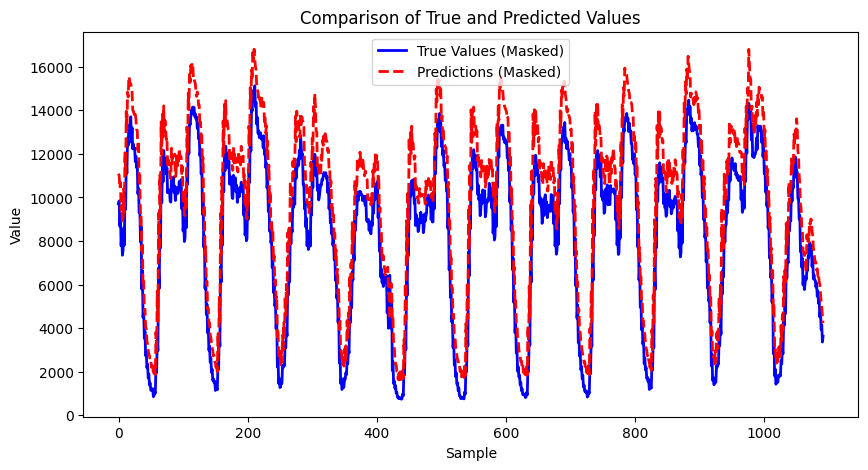

2024-07-25 17:32:34: OUTFLOW, MAE: 9.81, MAPE: 131.7618%


In [19]:
## mse
s, y_true, y_pred = test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

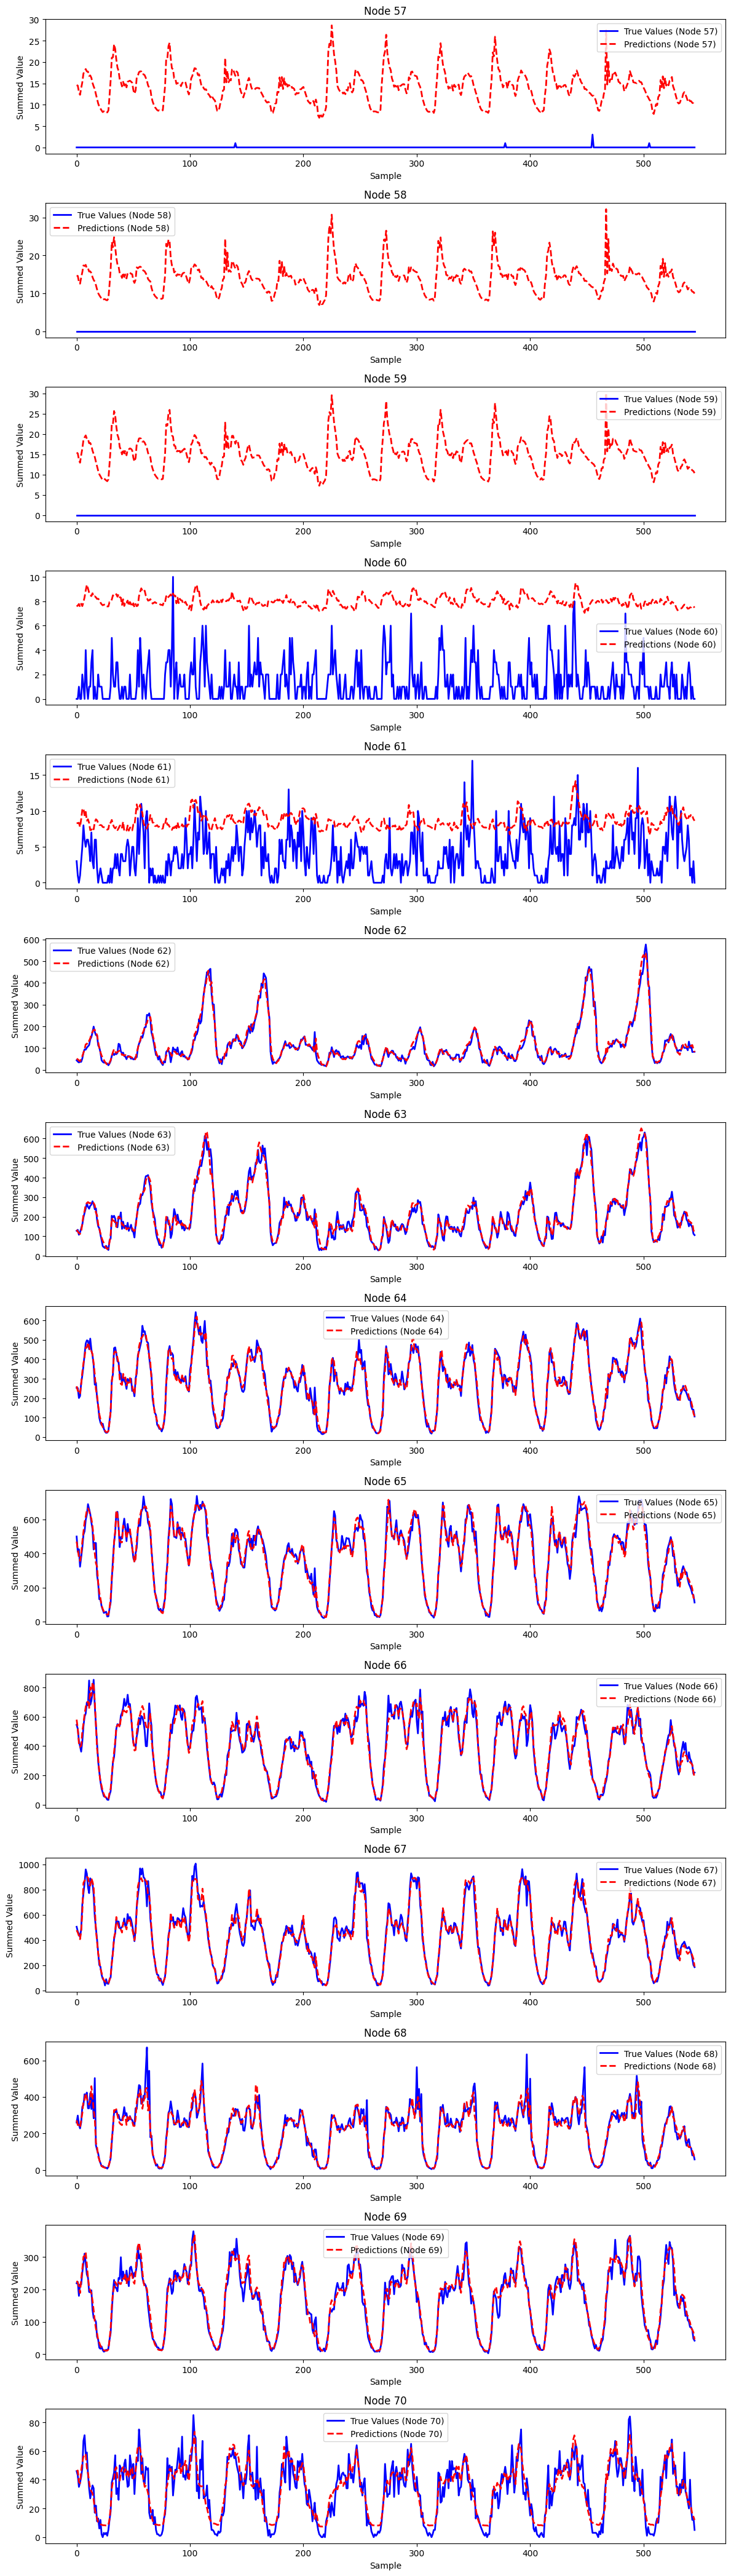

: 

In [20]:
# Adjusted range for nodes
start_node = 57
end_node = 70
num_nodes_to_plot = end_node - start_node + 1

# Create subplots for the adjusted range
fig, axs = plt.subplots(nrows=num_nodes_to_plot, ncols=1, figsize=(12, 3 * num_nodes_to_plot))

for node_index in range(start_node, end_node + 1):
    # Adjusted indexing for node_true and node_pred calculation
    node_true = np.nansum(y_true[:, :, node_index, 0], axis=(1,))
    node_pred = np.nansum(y_pred[:, :, node_index, 0], axis=(1,))
    
    # Adjusted indexing for axs
    ax = axs[node_index - start_node]
    
    ax.plot(node_true, label=f'True Values (Node {node_index})', color='blue', linewidth=2)
    ax.plot(node_pred, label=f'Predictions (Node {node_index})', color='red', linewidth=2, linestyle='--')
    ax.set_title(f'Node {node_index}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Summed Value')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Assume y_true, y_pred, and mask are defined as per your setup
masked_y_true = np.where(y_true > 5, y_true, 0)  # Apply masking
masked_y_pred = np.where(y_true > 5, y_pred, 0)  # Apply masking to y_pred based on y_true's mask

masked_y_true = y_true
masked_y_pred = y_pred

# Determine the number of nodes (assuming y_true.shape = [samples, prediction_horizon, num_nodes, inflow/outflow])
num_nodes = y_true.shape[2]

# Create subplots
fig, axs = plt.subplots(nrows=num_nodes, ncols=1, figsize=(12, 3 * num_nodes))  # Adjust the size accordingly

for node_index in range(num_nodes):
    # Sum across prediction_horizon and inflow/outflow dimensions, ignoring NaNs
    # node_true = np.nansum(masked_y_true[:, :, node_index, :], axis=(1, 2))
    # node_pred = np.nansum(masked_y_pred[:, :, node_index, :], axis=(1, 2))
    
    node_true = np.nansum(masked_y_true[:, :, node_index, 0], axis=(1,))
    node_pred = np.nansum(masked_y_pred[:, :, node_index, 0], axis=(1,))
    
    if num_nodes > 1:
        ax = axs[node_index]
    else:
        ax = axs
    
    ax.plot(node_true, label=f'True Values (Node {node_index})', color='blue', linewidth=2)
    ax.plot(node_pred, label=f'Predictions (Node {node_index})', color='red', linewidth=2, linestyle='--')
    ax.set_title(f'Node {node_index}')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Summed Value')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [35]:
state_dict = torch.load(
    args.best_path,
    map_location=torch.device(args.device)
)
model.load_state_dict(state_dict['model'])
print("Load saved model")
results = trainer.test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

Load saved model


2024-07-03 12:10:57: INFLOW, MAE: 11.79, MAPE: 16.1882%
2024-07-03 12:10:57: OUTFLOW, MAE: 9.65, MAPE: 16.5495%


In [27]:

def test_rolling(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    prediction_buffer = None  # Buffer to hold predictions for future time steps

    # torch.Size([batch_size=1, time_steps=19, no.ofnodes=285, features=1]) data shape
    # torch.Size([1, 1, 285, 1]) pred_output shape
    # print("len(dataloader): ", len(dataloader))
    with torch.no_grad():
        for idx, (data, target) in enumerate(dataloader):
            # print(f"idx: {idx}, data.shape: {data.shape}, target.shape: {target.shape}")
            # Update data with predictions from buffer
            if prediction_buffer is not None:
                for t in range(len(prediction_buffer)):
                    if t <= data.shape[1]:  # Ensure the time step exists in the data
                        # print("data.shape: ", data.shape, "data[:, t, :, :].shape: ", data[:, t, :, :].shape, "prediction_buffer[t].shape: ", prediction_buffer[t].shape)
                        # print(f"for data at index {idx} replacing data[:, {t}, :, :] with prediction_buffer[{t}]")
                        data[:, t, :, :] = prediction_buffer[t].squeeze(1)

            repr1, repr2 = model(data, graph)
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)

            # Update the prediction buffer
            if prediction_buffer is None:
                prediction_buffer = [pred_output]
            else:
                prediction_buffer.insert(0, pred_output)  ## insert at 0th index
                prediction_buffer = prediction_buffer[:data.shape[1]]  # Keep buffer size same as the number of time steps

    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    # y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    # y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()

    test_results = []

    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:3100], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:3100], label='Predictions')
    ## to plot summed up regions
    plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten(), label='True Values')
    plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("rolling, MAE: {:.2f}, rolling MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])

    return np.stack(test_results, axis=0)

y_true.shape:  (864, 1, 128, 2) y_pred.shape:  (864, 1, 128, 2)


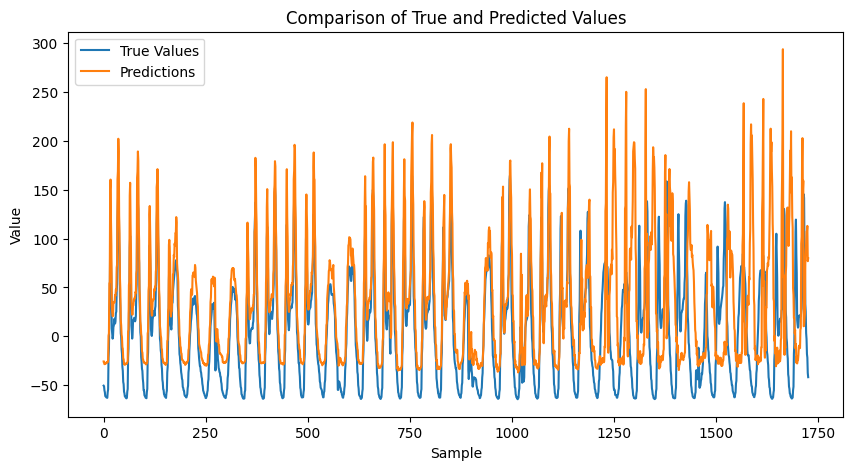

2024-02-07 02:01:54: rolling, MAE: 0.50, rolling MAPE: 129.6789%


array([[0.49504986, 1.296789  ]], dtype=float32)

In [9]:
test_rolling(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

In [10]:
# args.best_path = r"D:\omer\ST-SSL\experiments\Careem_linear\20240130-100155\best_model.pth"
# state_dict = torch.load(
#                 args.best_path,
#                 map_location=torch.device(args.device)
#             )
# model.load_state_dict(state_dict['model'])
# print("Load saved model")
# results = trainer.test(model, dataloader['test'], dataloader['scaler'],
#             graph, trainer.logger, trainer.args)
# results_rolling = trainer.test_rolling(model, dataloader['test'], dataloader['scaler'],
#             graph, trainer.logger, trainer.args)

In [11]:
# def read_data(file_path):
#     preds = []
#     true_labels = []
#     with open(file_path, 'r') as file:
#         for line in file:
#             pred, true_label = line.strip().split(',')
#             preds.append(float(pred))
#             true_labels.append(int(true_label))
#     return preds, true_labels

# preds, true_labels = read_data(r"D:\omer\c2d2\surgvisdom_pred.txt")

In [12]:
# import numpy as np
# from sklearn.metrics import f1_score, balanced_accuracy_score

# def val_metrics(preds, true_labels, indices):
    

#     mean_weighted_f1 = 0.0
#     mean_unweighted_f1 = 0.0
#     mean_global_f1 = 0.0
#     mean_balanced_acc = 0.0

#     for i in range(15):
#         start_idx = indices[i]
#         end_idx = indices[i + 1]

#         group_preds = preds[start_idx:end_idx]
#         group_true_labels = true_labels[start_idx:end_idx]

#         mean_weighted_f1 += f1_score(group_true_labels, group_preds, average='weighted') / 16.0
#         mean_unweighted_f1 += f1_score(group_true_labels, group_preds, average='macro') / 16.0
#         mean_global_f1 += f1_score(group_true_labels, group_preds, average='micro') / 16.0
#         mean_balanced_acc += balanced_accuracy_score(group_true_labels, group_preds) / 16.0

#     print('Weighted F1: {}'.format(mean_weighted_f1))
#     print('Unweighted F1: {}'.format(mean_unweighted_f1))
#     print('Global F1: {}'.format(mean_global_f1))
#     print('Balanced Accuracy: {}'.format(mean_balanced_acc))

#     return mean_weighted_f1, mean_unweighted_f1, mean_global_f1, mean_balanced_acc

# indices = [0, 209, 381, 997, 1132, 1288, 1428, 1742, 1796, 2041, 2202, 2959, 3124, 3308, 3789, 4385, 4496]

# results = val_metrics(preds, true_labels, indices)


In [13]:
# import numpy as np

# diff_indices = np.diff(indices)
# print(diff_indices)
